In [1]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner


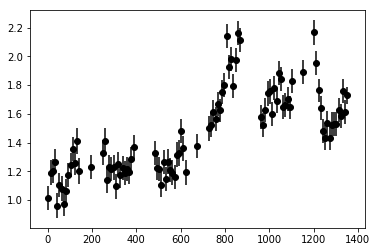

In [2]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/2M1314e15-LLRR.dat')
binned = binning(dt,sec=10)
plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k')
plt.scatter(binned['secs'],binned['re'],color='black')
plt.show()

In [3]:
'''
Defining our model, likelihoood, and prior functions
'''
def model(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if 0 < m < 0.01 and .5 < b < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-model(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [4]:
# Putting data to variables
x = binned['secs']
y = binned['re']
yerr = binned['ure']

In [5]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [0.000125,1.15]
result = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = result.x

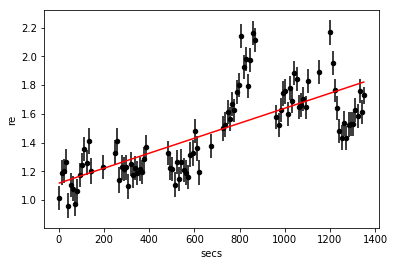

In [6]:
# Plotting results from maximized likelihood

binned.plot.scatter('secs','re',yerr='ure',color='black',marker='o')
plt.plot(x,model([m_ml,b_ml],x),color='red')
plt.show()

In [7]:
'''
Running MCMC
'''

# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [result['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = sampler.run_mcmc(p0,100)
sampler.reset()

# Running MCMC
sampler.run_mcmc(pos,2000)

(array([[5.29410960e-04, 1.12621276e+00],
        [5.24737935e-04, 1.11661016e+00],
        [5.47928398e-04, 1.09055208e+00],
        [5.48835196e-04, 1.10947731e+00],
        [5.25435214e-04, 1.10786898e+00],
        [5.00244844e-04, 1.13846513e+00],
        [5.12941731e-04, 1.12892431e+00],
        [5.55875253e-04, 1.08361302e+00],
        [5.20239668e-04, 1.11389650e+00],
        [4.79457239e-04, 1.13926235e+00],
        [5.35963940e-04, 1.11586709e+00],
        [4.62781832e-04, 1.14467762e+00],
        [4.94996046e-04, 1.13477740e+00],
        [5.64031508e-04, 1.09105295e+00],
        [5.31896217e-04, 1.09355678e+00],
        [5.28673720e-04, 1.12344498e+00],
        [5.26339467e-04, 1.10934611e+00],
        [5.24904883e-04, 1.10765096e+00],
        [5.53434072e-04, 1.09751410e+00],
        [4.90493495e-04, 1.13731320e+00],
        [5.37315236e-04, 1.12245738e+00],
        [5.30644093e-04, 1.12406169e+00],
        [5.16148788e-04, 1.13570604e+00],
        [5.19178089e-04, 1.1284774

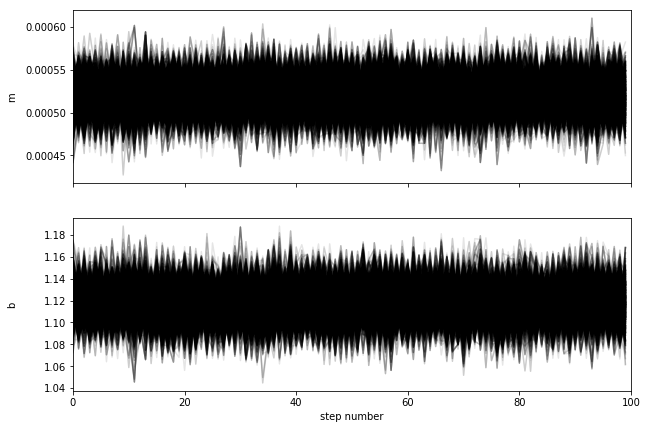

In [8]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
samples = sampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.show()

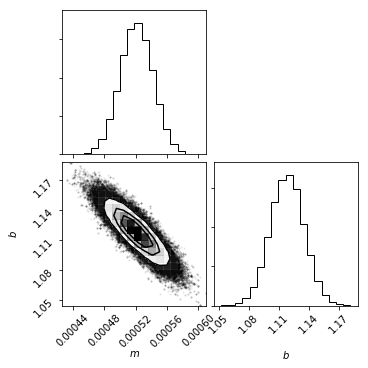

In [9]:
# Flattening the sampler
flat_samples = sampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(flat_samples,labels=['$m$','$b$'])
plt.show()

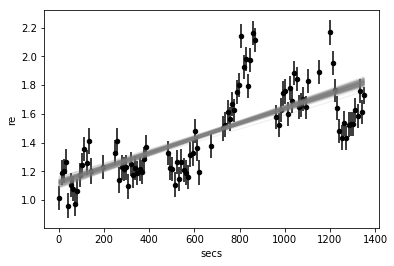

In [10]:
# Plotting first few MCMC steps on the data
binned.plot.scatter('secs','re',yerr='ure',color='k')
for m,b in flat_samples[np.random.randint(len(flat_samples),size=100)]:
    plt.plot(binned['secs'],m*binned['secs']+b,color='gray',alpha=0.1)
plt.show()

In [11]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

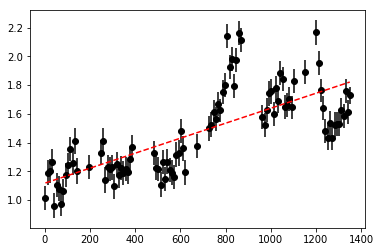

In [12]:
# Getting the 50th percentile of each parameter
parameters = []

for i in range(ndim):
    parameters.append(np.percentile(flat_samples[:,i],50))
parameters = np.array(parameters)

# Making model line
model_line = model(parameters,x)

# Plotting against the data
plt.scatter(x,y,color='k',marker='o')
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None')
plt.plot(x,model_line,color='red',linestyle='dashed')
plt.show()

## Fitting an exponential function


In [13]:
def logmodel(theta,x):
    '''
    Logarithmic model
    '''
    a,b = theta
    denom = 1+np.exp(b*x+a)
    return 1/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logmodel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    a,b = theta
    if -12 < a < 0 and -12 < b < 0:
        return 0.0
    return -np.inf

In [14]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [-2,5]
result = op.minimize(nll,x0,args=(x,y,yerr))
a_ml,b_ml = result.x
print(a_ml,b_ml)

-7.33203125 -8.330078125


/home/russell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


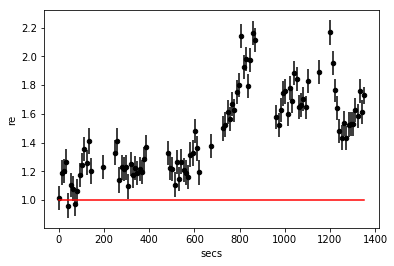

In [15]:
# Plotting results from maximized likelihood
binned.plot.scatter('secs','re',yerr='ure',color='black',marker='o')
plt.plot(x,logmodel([a_ml,b_ml],x),color='red')
plt.show()

In [16]:
# Doing a fourier transformation of the data
fourier = np.fft.fft(y)



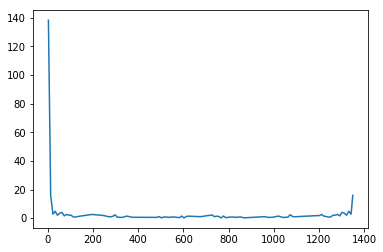

In [17]:
plt.plot(x,np.abs(fourier))
plt.show()